In [43]:
# Import libraries needed for the analysis
import os
import pandas as pd
import numpy as np

from datetime import datetime
import random
import string

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 5
from numpy.random import seed
seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
# Read the training and test datasets
train_tweets = pd.read_csv("/Users/kerry//Projects/grad_school_portfolio/Fall2020/MSDS422/rnn/data/train.csv")
test_tweets = pd.read_csv("/Users/kerry//Projects/grad_school_portfolio/Fall2020/MSDS422/rnn/data/test.csv")
#train_tweets= pd.read_csv('/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week8/project1/nlp-getting-started/train.csv')
#test_tweets=pd.read_csv('/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week8/project1/nlp-getting-started/test.csv')

In [5]:
train_tweets.shape

(7613, 5)

In [6]:
test_tweets.shape

(3263, 4)

In [7]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
test_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [9]:
train_tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# drops dups (retweets)
train_tweets[train_tweets.duplicated(subset="text", keep='first')==False]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1


In [11]:
# drops ~ 5-10 records most of which I find misclassified
train_tweets[(train_tweets.keyword=="blaze") & (train_tweets.target==1)]

,id,keyword,location,text,target
647,938,blaze,"Temecula, CA",Pendleton media office said only fire on base ...,1
649,940,blaze,"Fresno, CA",Love living on my own. I can blaze inside my a...,1
653,945,blaze,Australia,Property losses from California wildfire nearl...,1
654,946,blaze,"Raleigh Durham, NC",#breaking Firefighters battling blaze at east ...,1
669,964,blaze,Karachi,Property losses from #California wildfire near...,1


In [60]:
#Create a dataframe to store the model accuracy and scores
results_tbl = pd.DataFrame(columns=['Model_name','vocabulary size (factor1)', 'pre-trained vector (factor2)','RNN structure (factor3)','hyperparameter recurrent_dropout (factor4)','Processing Time','Training Set Accuracy','Validation Set Accuracy','train f1','validation f1','Test Set F1-score (Kaggle score)'])
results_tbl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 11 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Model_name                                  0 non-null      object
 1   vocabulary size (factor1)                   0 non-null      object
 2   pre-trained vector (factor2)                0 non-null      object
 3   RNN structure (factor3)                     0 non-null      object
 4   hyperparameter recurrent_dropout (factor4)  0 non-null      object
 5   Processing Time                             0 non-null      object
 6   Training Set Accuracy                       0 non-null      object
 7   Validation Set Accuracy                     0 non-null      object
 8   train f1                                    0 non-null      object
 9   validation f1                               0 non-null      object
 10  Test Set F1-score (Kaggle score)           

# Exploratory Data Analysis & Data Preparation

Text(0.5, 1.0, 'target count plot in the training data (0 - not a real disaster, 1 - a real disaster)')

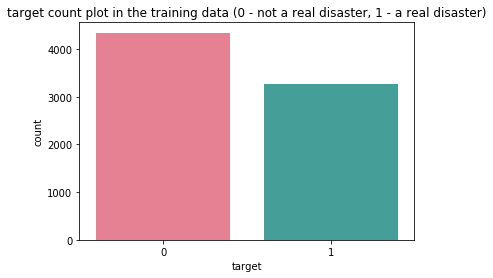

In [13]:
# Count plot of the targets in training data 
sns.countplot(train_tweets['target'], palette="husl")
plt.title('target count plot in the training data (0 - not a real disaster, 1 - a real disaster)')

In [14]:
# check for any null values 
# the variable of interest in the data is text.
train_tweets.isna().sum() 

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [15]:
# Distribution of the length of the tweets in the training data
#fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
#disaster_tweets_len=train_tweets[train_tweets['target']==1]['text'].str.len()
#nondisaster_tweets_len=train_tweets[train_tweets['target']==0]['text'].str.len()
#sns.histplot(disaster_tweets_len, ax=ax1, color="g")
#ax1.set_title('Length of the disaster tweets in training data')
#sns.histplot(nondisaster_tweets_len, ax=ax2, color="r")
#ax2.set_title('Length of the non-disaster tweets in training data')
#plt.show()

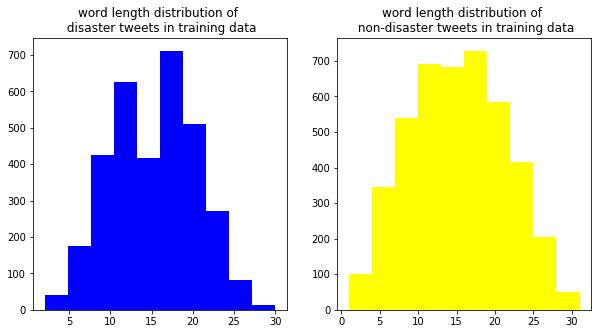

In [16]:
# Distribution of the word lengths of the tweets in the  training data
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
diaster_tweet_lengths=train_tweets[train_tweets['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(diaster_tweet_lengths,color='blue')
ax1.set_title('word length distribution of \n disaster tweets in training data')
nondisaster_tweet_lengths=train_tweets[train_tweets['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(nondisaster_tweet_lengths,color='yellow')
ax2.set_title('word length distribution of \n non-disaster tweets in training data')
plt.show()

# Read function for the  GloVe (global vectors) 

In [17]:
#reading from the file to turn the words to word embedding vector
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

## Read the Glove file - glove.6B.50d.txt

In [18]:
#reading from the file to learn the word embedding into the list word_to_vec_map
#word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week8/project1/nlp-getting-started/embeddings/gloVe.6B/glove.6B.50d.txt')
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/Users/kerry/Downloads/embeddings/gloVe.6B/glove.6B.50d.txt')

In [19]:
len(word_to_index)

400000

In [20]:
len(word_to_vec_map)

400000

In [21]:
len(index_to_word)

400000

## Cleanse the training and test data 
## Use the word_to_vec_map from glove.6B.50d

In [22]:
def clean(text):
#    rgx_fix_caps = "(?<=[\.!?]\s)([A-Z])" # fixes like Hello into hello???
#    subst = r"\\"
#    pre_sentence = re.sub(rgx_fix_caps, subst, text)
    
    rgx_rmv_punc = re.compile('([^\s\w]|_)+') # removes punctuation
    sentence = rgx_rmv_punc.sub("", text).lower()
    
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word not in word_to_vec_map: # removes word if it's not in the 'dictionary' (txt file). case-sensitive.
            sentence.remove(word)
            
    sentence = " ".join(sentence)
    return sentence

In [23]:
clean(train_tweets.loc[2,'text'])

'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected'

In [24]:
for i in range (train_tweets.shape[0]):
    train_tweets.at[i,'text']=clean(train_tweets.loc[i,'text'])
    
for i in range(test_tweets.shape[0]):
    test_tweets.at[i,'text']=clean(test_tweets.loc[i,'text'])

In [25]:
train_text = train_tweets['text']
test_text = test_tweets['text']

# Encode the text in the training data
# Pad the resultant sequences

In [26]:
# https://stackoverflow.com/questions/57693333/processing-before-or-after-train-test-split
# https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_text)

In [27]:
train_sequences = tokenizer.texts_to_sequences(train_text)

In [28]:
tokenizer.texts_to_sequences(["Forest fire near La Ronge Sask. Canada"])

[[178, 42, 214, 664, 6037, 6038, 1319]]

In [29]:
tokenizer.sequences_to_texts([[178, 42, 214, 664, 6037, 6038, 1319]])

['forest fire near la ronge sask canada']

In [30]:
word2index = tokenizer.word_index
print("Number of unique tokens : ",len(word2index))

Number of unique tokens :  12256


In [31]:
dataset_size = tokenizer.document_count
dataset_size

7613

In [32]:
# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
maxlen

31

In [33]:
padded_seq = keras.preprocessing.sequence.pad_sequences(train_sequences,maxlen)
X_train = padded_seq
Y_train = train_tweets['target']
X_train.shape

(7613, 31)

# Generate embedding matrix for tokens in the training data - 50 Dimensions

In [34]:
embedding_matrix = np.zeros((len(word2index)+1,50))

embedding_vec=[]
for word, i in word2index.items():
    embedding_vec = word_to_vec_map.get(word)
    if embedding_vec is not None:
        embedding_matrix[i] = embedding_vec

In [35]:
print(embedding_matrix[1])

[ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]


In [36]:
print(embedding_matrix.shape)

(12257, 50)


# Fit RNN 1
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.50d
# rnn structure (factor 3): LSTM layer based structure
# recurrent dropout (factor 4): 0.1

In [37]:
model1 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,50,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [38]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 50)            612850    
_________________________________________________________________
lstm (LSTM)                  (None, 31, 128)           91648     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 756,019
Trainable params: 143,169
Non-trainable params: 612,850
_________________________________________________________________


In [45]:
opt=Adam(learning_rate=1e-5)
model1.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [46]:
# Fit the model; obtain the model fit time
start=datetime.now()
history1 = model1.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=30,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 18s 111ms/step - loss: 0.6899 - accuracy: 0.5294 - f1_m: 0.3271 - val_loss: 0.6805 - val_accuracy: 0.6038 - val_f1_m: 0.2494
Epoch 2/40
167/167 [==============================] - 19s 112ms/step - loss: 0.6699 - accuracy: 0.6690 - f1_m: 0.4568 - val_loss: 0.6573 - val_accuracy: 0.7172 - val_f1_m: 0.4316
Epoch 3/40
167/167 [==============================] - 21s 124ms/step - loss: 0.6480 - accuracy: 0.7247 - f1_m: 0.5869 - val_loss: 0.6306 - val_accuracy: 0.7680 - val_f1_m: 0.5311
Epoch 4/40
167/167 [==============================] - 23s 140ms/step - loss: 0.6213 - accuracy: 0.7607 - f1_m: 0.6714 - val_loss: 0.5977 - val_accuracy: 0.7728 - val_f1_m: 0.5542
Epoch 5/40
167/167 [==============================] - 23s 140ms/step - loss: 0.5902 - accuracy: 0.7630 - f1_m: 0.6896 - val_loss: 0.5627 - val_accuracy: 0.7863 - val_f1_m: 0.5835
Epoch 6/40
167/167 [==============================] - 24s 141ms/step - loss: 0.5589 - accuracy: 0.7664 - 

In [63]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history1.history['accuracy'][np.argmin(history1.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.7956

In [64]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history1.history['val_accuracy'][np.argmin(history1.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8078

In [65]:
best_model_train_f1 = max(np.round(history1.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history1.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

Best Train f1: 0.7315
Best val f1: 0.629


In [ ]:
# Plot the learning curve
pd.DataFrame(history1.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve -  factor1: 400K, factor2: GloVe.6B.50d, factor3: LSTM, factor4: 0.1')
plt.show()

# Prepare the test data

In [57]:
test_sequences = tokenizer.texts_to_sequences(test_text)
padded_seq = keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen)
X_test = padded_seq
X_test.shape

(3263, 31)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [ ]:
predict1 = model1.predict_classes(X_test)
predict1

In [ ]:
len(predict1)

In [ ]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict1)})
submission_df.to_csv('submission_rnn_1.csv',index=False)

In [61]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #1', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.50d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': '0.78087'
                                   },ignore_index=True)
results_tbl


,Model_name,vocabulary size (factor1),pre-trained vector (factor2),RNN structure (factor3),hyperparameter recurrent_dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,train f1,validation f1,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,00:14:57.115241,0.7956,0.8078,0.7315,0.629,0.78087


# Fit RNN 2
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.50d
# rnn structure (factor 3): LSTM layer based structure
# recurrent dropout (factor 4): 0.3

In [66]:
model2 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,50,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1,activation='tanh')
])

In [67]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 50)            612850    
_________________________________________________________________
lstm_2 (LSTM)                (None, 31, 128)           91648     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 756,019
Trainable params: 143,169
Non-trainable params: 612,850
_________________________________________________________________


In [68]:
opt=Adam(learning_rate=1e-5)
model2.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [ ]:
# Fit the model; obtain the model fit time
start=datetime.now()
history2 = model2.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 24s 142ms/step - loss: 1.2531 - accuracy: 0.5752 - f1_m: 5.7029e-04 - val_loss: 0.9155 - val_accuracy: 0.5582 - val_f1_m: 0.0000e+00
Epoch 2/40
167/167 [==============================] - 22s 134ms/step - loss: 0.9891 - accuracy: 0.5744 - f1_m: 0.0088 - val_loss: 0.8608 - val_accuracy: 0.5582 - val_f1_m: 0.0012
Epoch 3/40
167/167 [==============================] - 21s 125ms/step - loss: 0.8963 - accuracy: 0.5648 - f1_m: 0.0207 - val_loss: 0.8180 - val_accuracy: 0.5539 - val_f1_m: 0.0189
Epoch 4/40
167/167 [==============================] - 21s 125ms/step - loss: 0.8444 - accuracy: 0.5600 - f1_m: 0.0617 - val_loss: 0.7833 - val_accuracy: 0.5429 - val_f1_m: 0.0893
Epoch 5/40
167/167 [==============================] - 22s 133ms/step - loss: 0.8117 - accuracy: 0.5594 - f1_m: 0.1263 - val_loss: 0.7633 - val_accuracy: 0.5429 - val_f1_m: 0.1761
Epoch 6/40
167/167 [==============================] - 24s 141ms/step - loss: 0.8063 - accuracy: 0

In [ ]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history2.history['accuracy'][np.argmin(history2.history['loss'])],4)
best_model_train_accuracy

In [ ]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history2.history['val_accuracy'][np.argmin(history2.history['val_loss'])],4)
best_model_val_accuracy

In [ ]:
best_model_train_f1 = max(np.round(history2.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history2.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

In [ ]:
best_model_train_f1 = max(np.round(history2.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history2.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

In [ ]:
# Plot the learning curve
pd.DataFrame(history2.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve -  factor1: 400K, factor2: GloVe.6B.50d, factor3: LSTM, factor4: 0.3')
plt.show()

# Re-use the X_test obtained earlier 

In [ ]:
X_test.shape

In [ ]:
X_test

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [ ]:
predict2 = model2.predict_classes(X_test)
predict2

In [ ]:
len(predict2)

In [ ]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict2)})
submission_df.to_csv('submission_rnn_2.csv',index=False)

In [ ]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #2', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.50d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': '0.78026'
                                   },ignore_index=True)
results_tbl


# Fit RNN 3
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.50d
# rnn structure (factor 3): GRU layer based structure
# recurrent dropout (factor 4): 0.1

In [ ]:
model3 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,50,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1,activation='tanh')
])

In [ ]:
model3.summary()

In [ ]:
opt=Adam(learning_rate=1e-5)
model3.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [ ]:
# Fit the model; obtain the model fit time
start=datetime.now()
history3 = model3.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

In [ ]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history3.history['accuracy'][np.argmin(history3.history['loss'])],4)
best_model_train_accuracy

In [ ]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history3.history['val_accuracy'][np.argmin(history3.history['val_loss'])],4)
best_model_val_accuracy

In [ ]:
best_model_train_f1 = max(np.round(history3.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history3.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

In [ ]:
# Plot the learning curve
pd.DataFrame(history3.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.50d, factor3: GRU, factor4: 0.1')
plt.show()

# Re-use the X_test obtained earlier

In [ ]:
X_test

In [ ]:
X_test.shape

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [ ]:
predict3 = model3.predict_classes(X_test)
predict3

In [ ]:
len(predict3)

In [ ]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict3)})
submission_df.to_csv('submission_rnn_3.csv',index=False)

In [ ]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #3', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.50d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': '0.78302'
                                   },ignore_index=True)
results_tbl


# Fit RNN 4
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.50d
# rnn structure (factor 3): GRU based structure
# recurrent dropout (factor 4): 0.3

In [ ]:
model4 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,50,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1,activation='tanh')
])

In [ ]:
model4.summary()

In [ ]:
opt=Adam(learning_rate=1e-5)
model4.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [ ]:
# Fit the model; obtain the model fit time
start=datetime.now()
history4 = model4.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

In [ ]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history4.history['accuracy'][np.argmin(history4.history['loss'])],4)
best_model_train_accuracy

In [ ]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history4.history['val_accuracy'][np.argmin(history4.history['val_loss'])],4)
best_model_val_accuracy

In [ ]:
best_model_train_f1 = max(np.round(history4.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history4.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

In [ ]:
# Plot the learning curve
pd.DataFrame(history4.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.50d, factor3: GRU, factor4: 0.3')
plt.show()


# Re-use the X_test obtained earlier

In [ ]:
X_test

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [ ]:
predict4 = model4.predict_classes(X_test)
predict4


In [ ]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict4)})
submission_df.to_csv('submission_rnn_4.csv',index=False)


In [ ]:

#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #4', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.50d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': '0.77873'
                                   },ignore_index=True)
results_tbl

## Read the Glove file - gloVe.6B.200d.txt

In [ ]:
#reading from the file to learn the word embedding into the list word_to_vec_map
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week8/project1/nlp-getting-started/embeddings/gloVe.6B/glove.6B.200d.txt')


In [ ]:
len(word_to_index)

In [ ]:
len(word_to_vec_map)

In [ ]:
len(index_to_word)

## Cleanse the training and test data 
## Use the word_to_vec_map from glove.6B.200d

In [ ]:
# clean the training and test data using the glove.6B.200d word_to_vec_map
for i in range (train_tweets.shape[0]):
    train_tweets.at[i,'text']=clean(train_tweets.loc[i,'text'])
    
for i in range(test_tweets.shape[0]):
    test_tweets.at[i,'text']=clean(test_tweets.loc[i,'text'])

In [ ]:
train_text = train_tweets['text']
test_text = test_tweets['text']

# Encode the text in the training data
# Pad the resultant sequences

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_text)

In [ ]:

train_sequences = tokenizer.texts_to_sequences(train_text)

In [ ]:
tokenizer.texts_to_sequences(["Forest fire near La Ronge Sask. Canada"])

In [ ]:
tokenizer.sequences_to_texts([[178, 42, 214, 664, 6037, 6038, 1319]])

In [ ]:
word2index = tokenizer.word_index
print("Number of unique tokens : ",len(word2index))

In [ ]:

dataset_size = tokenizer.document_count
dataset_size

In [ ]:
# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
maxlen


In [ ]:
padded_seq = keras.preprocessing.sequence.pad_sequences(train_sequences,maxlen)
X_train = padded_seq
Y_train = train_tweets['target']
X_train.shape


# Generate embedding matrix for tokens in the training data - 200 Dimensions

In [ ]:
embedding_matrix = np.zeros((len(word2index)+1,200))

embedding_vec=[]
for word, i in word2index.items():
    embedding_vec = word_to_vec_map.get(word)
    if embedding_vec is not None:
        embedding_matrix[i] = embedding_vec


In [ ]:
print(embedding_matrix[1])

In [ ]:
print(embedding_matrix.shape)

# Fit RNN 5
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.200d
# rnn structure (factor 3): LSTM layer based structure
# recurrent dropout (factor 4): 0.1

In [ ]:
model5 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1,activation='tanh')
])

In [ ]:
model5.summary()

In [ ]:
opt=Adam(learning_rate=1e-5)
model5.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [ ]:
# Fit the model; obtain the model fit time
start=datetime.now()
history5 = model5.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.1
)
end=datetime.now()
print(end-start)

In [ ]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history5.history['accuracy'][np.argmin(history5.history['loss'])],4)
best_model_train_accuracy

In [ ]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history5.history['val_accuracy'][np.argmin(history5.history['val_loss'])],4)
best_model_val_accuracy

In [ ]:
best_model_train_f1 = max(np.round(history5.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history5.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

In [ ]:

# Plot the learning curve
pd.DataFrame(history5.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.200d, factor3: LSTM, factor4: 0.1')
plt.show()

# Prepare the test data

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_text)
padded_seq = keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen)
X_test = padded_seq
X_test.shape

In [ ]:

predict5 = model5.predict_classes(X_test)
predict5

In [ ]:
len(predict5)

In [ ]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict5)})
submission_df.to_csv('submission_rnn_5.csv',index=False)


In [ ]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #5', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': '0.79313'
                                   },ignore_index=True)
results_tbl

# Fit RNN 6
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.200d
# rnn structure (factor 3): LSTM layer based structure
# recurrent dropout (factor 4): 0.3


In [ ]:
model6 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1,activation='tanh')
])

In [ ]:
model6.summary()

In [ ]:
opt=Adam(learning_rate=1e-5)
model6.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [ ]:
# Fit the model; obtain the model fit time
start=datetime.now()
history6 = model6.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

In [ ]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history6.history['accuracy'][np.argmin(history6.history['loss'])],4)
best_model_train_accuracy

In [ ]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history6.history['val_accuracy'][np.argmin(history6.history['val_loss'])],4)
best_model_val_accuracy


In [ ]:
best_model_train_f1 = max(np.round(history6.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history6.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

In [ ]:

# Plot the learning curve
pd.DataFrame(history6.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.200d, factor3: LSTM, factor4: 0.3')
plt.show()

# Re-use the X_test obtained earlier 

In [ ]:
X_test.shape

In [ ]:
X_test

In [ ]:
# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [ ]:

predict6 = model6.predict_classes(X_test)
predict6

In [ ]:
len(predict6)

In [ ]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict6)})
submission_df.to_csv('submission_rnn_6.csv',index=False)


In [ ]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #6', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': '0.78639'
                                   },ignore_index=True)
results_tbl

# Fit RNN 7
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.200d
# rnn structure (factor 3): GRU layer based structure
# recurrent dropout (factor 4): 0.1


In [ ]:

model7 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1,activation='tanh')
])

In [ ]:
model7.summary()

In [ ]:
opt=Adam(learning_rate=1e-5)
model7.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)

In [ ]:
# Fit the model; obtain the model fit time
start=datetime.now()
history7 = model7.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)



In [ ]:

print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history7.history['accuracy'][np.argmin(history7.history['loss'])],4)
best_model_train_accuracy


In [ ]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history7.history['val_accuracy'][np.argmin(history7.history['val_loss'])],4)
best_model_val_accuracy

In [ ]:
best_model_train_f1 = max(np.round(history7.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history7.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

In [ ]:
# Plot the learning curve
pd.DataFrame(history7.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.200d, factor3: GRU, factor4: 0.1')
plt.show()


In [ ]:
# Re-use the X_test obtained earlier

In [ ]:
X_test

In [ ]:
X_test.shape

# Make the prediction on the test data

# 1 - disaster tweet , 0 - non-disaster tweet


In [ ]:

predict7 = model7.predict_classes(X_test)
predict7

In [ ]:
len(predict7)

In [ ]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict7)})
submission_df.to_csv('submission_rnn_7.csv',index=False)

In [ ]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #7', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': '0.79068'
                                   },ignore_index=True)
results_tbl


# Fit RNN 8
# vocabulary size (factor 1): 400K
# pre-trained vector (factor 2): GloVe.6B.200d
# rnn structure (factor 3): GRU based structure
# recurrent dropout (factor 4): 0.3

In [ ]:
model8 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1,activation='tanh')
])


In [ ]:
model8.summary()

In [ ]:
opt=Adam(learning_rate=1e-5)
model8.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy', f1_m],
)


In [ ]:

# Fit the model; obtain the model fit time
start=datetime.now()
history8 = model8.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

In [ ]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history8.history['accuracy'][np.argmin(history8.history['loss'])],4)
best_model_train_accuracy

In [ ]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history8.history['val_accuracy'][np.argmin(history8.history['val_loss'])],4)
best_model_val_accuracy

In [ ]:
best_model_train_f1 = max(np.round(history8.history['f1_m'],4))
print ('Best Train f1: {}'.format(best_model_train_f1))

best_model_val_f1 = max(np.round(history8.history['val_f1_m'],4))
print ('Best val f1: {}'.format(best_model_val_f1))

In [ ]:
# Plot the learning curve
pd.DataFrame(history8.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.200d, factor3: GRU, factor4: 0.3')
plt.show()

# Re-use the X_test obtained earlier

In [ ]:
X_test

In [ ]:
X_test.shape

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [ ]:
predict8 = model8.predict_classes(X_test)
predict8


In [ ]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict8)})
submission_df.to_csv('submission_rnn_8.csv',index=False)


In [ ]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #8', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter recurrent_dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'train f1':best_model_train_f1,
                                   'validation f1':best_model_val_f1,
                                   'Test Set F1-score (Kaggle score)': '0.78608'
                                   },ignore_index=True)
results_tbl